<a href="https://colab.research.google.com/github/anthonymirandag/IndoorLocalization/blob/master/FingerprintingIndoorLocalization1D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import io
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
!pip install tensorflow-gpu==2.0.0.alpha0
import datetime
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

     |████████████████████████████████| 332.1MB 50kB/s 
     |████████████████████████████████| 3.0MB 52.1MB/s 
     |████████████████████████████████| 419kB 48.7MB/s 


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

# Enfoque de Series de tiempo con CNN.
El enfoque tomado que se desea probar en usar una 1D-CNN  con la idea de aprender las caracteristica de la serie de tiempo como una ventana deslizante de los valores rssi para cada uno de los sectores. [Convolutional Neural Networks in Keras for Time Sequences](https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf)


## Trasform data to image 

### Carga de datos

In [2]:
''' from google.colab import drive
drive.mount('/content/gdrive') '''

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#path_data = "/content/gdrive/My Drive/ProyectoTesis/datasets/Tx_0x01.csv"
path_data = 'https://raw.githubusercontent.com/anthonymirandag/IndoorLocalization/master/data/Tx_0x01.csv'
df = pd.read_csv(path_data)


### Visualizacion de valores rssi como series de tiempo del sector 1


In [0]:
df_1 = df[df.Sector == 1]

In [5]:
df_1.head()

,Be07,Be08,Be09,Be10,Be11,Sector
0,-68.0,-53.0,-53.0,-59.0,-69.0,1.0
1,-65.0,-61.0,-55.0,-57.0,-63.0,1.0
2,-69.0,-54.0,-53.0,-59.0,-70.0,1.0
3,-66.0,-62.0,-52.0,-52.0,-71.0,1.0
4,-69.0,-54.0,-55.0,-62.0,-68.0,1.0


In [6]:
df_1.shape # 458  leacturas en intervalos de tiempo para el sector uno

(458, 6)

In [0]:
n = df_1.shape[0]

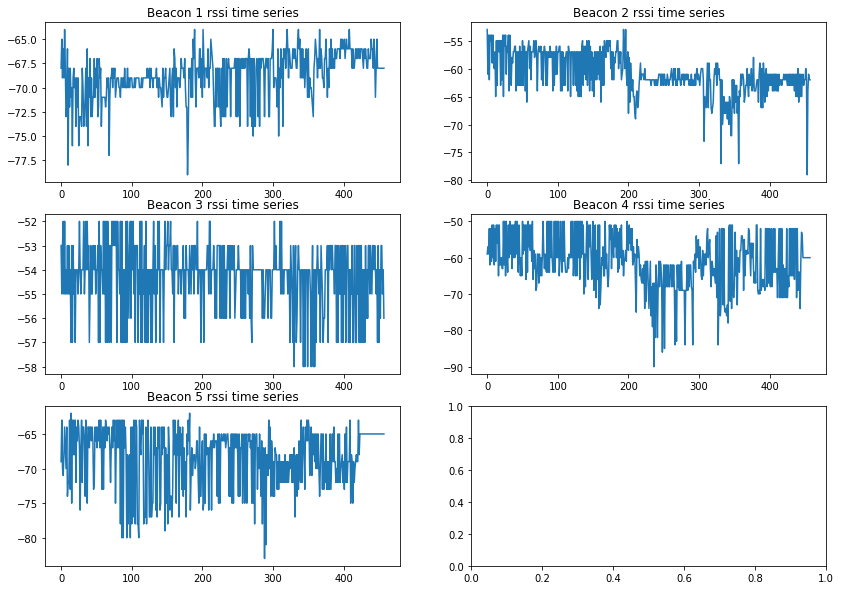

In [10]:
x_1 = [i for i in range(n)]
fig, axs = plt.subplots(3, 2,figsize=(14, 10))
for i in range(5) :
  y_1 = df_1.iloc[:,i].values
  col = int(i%2)
  row = int(i/2)
  axs[row,col].plot(x_1, y_1)
  axs[row,col].set_title('Beacon {} rssi time series'.format(i+1))

### Visualizacion de porción de valores rssi como series de tiempo del sector 1

In [0]:
tam_slices = 20 # Tamana de porcion utiliza para generar las images

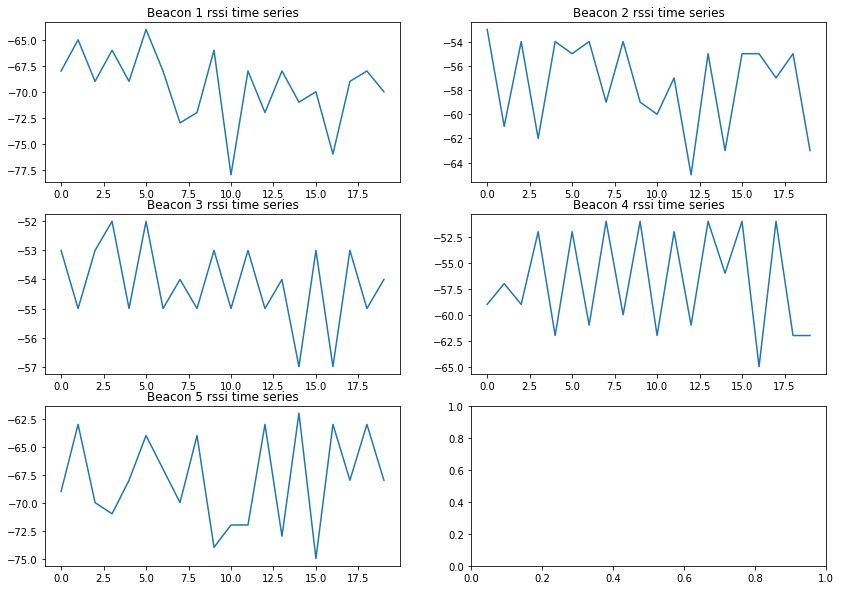

In [12]:
x_1 = [i for i in range(tam_slices)]
fig, axs = plt.subplots(3, 2,figsize=(14, 10))
for i in range(5) :
  y_1 = df_1.iloc[0:tam_slices,i].values
  col = int(i%2)
  row = int(i/2)
  axs[row,col].plot(x_1, y_1)
  axs[row,col].set_title('Beacon {} rssi time series'.format(i+1))

### Visualizacion de valores rssi como series de tiempo del sector 2

In [0]:
df_2 = df[df.Sector == 2]

In [0]:
n = df_2.shape[0]

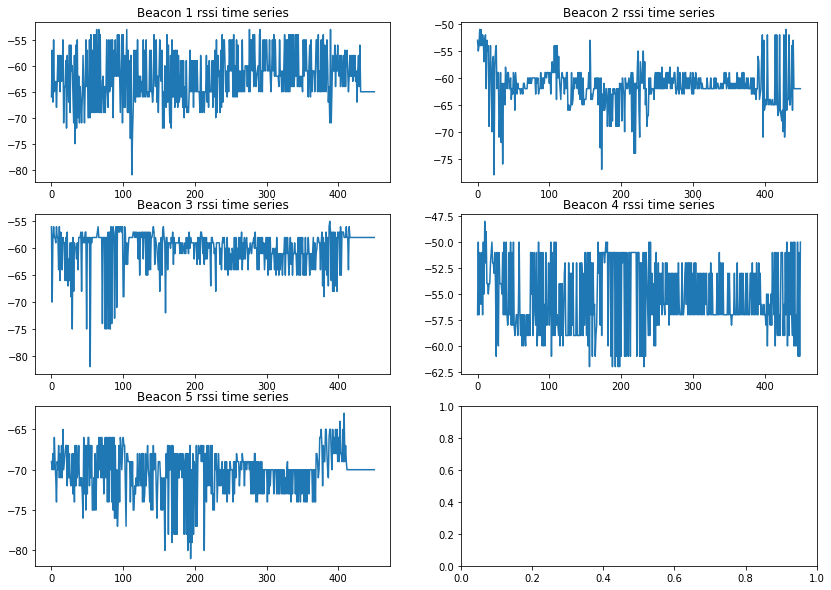

In [15]:
x_2 = [i for i in range(n)]
fig, axs = plt.subplots(3, 2,figsize=(14, 10))
for i in range(5) :
  y_2 = df_2.iloc[:,i].values
  col = int(i%2)
  row = int(i/2)
  axs[row,col].plot(x_2, y_2)
  axs[row,col].set_title('Beacon {} rssi time series'.format(i+1))

### Transfomacion de datos a imagen
  La imagen se genera de una porcion de la serie tiempo de tamando tomando 20 vectores de las lecturas de rssi para cada Punto acceso formandose imagenes de (num_rssi) X (num_puntos de acceso) . En esta cado 20 x 5

In [0]:
tam_slices = 20
target_label = 'Sector'

In [0]:
def transfrom_data_to_images(dataset,target_label ,shape = (20,5)):
  sectors = dataset[target_label].unique()
  x_images = np.array([])
  y_labels = np.array([])
  for sector  in sectors:
    df_sector = dataset[dataset.Sector == sector]
    x_sector =  df_sector.drop(target_label, axis= 1).values
    residual_elem = x_sector.shape[0] % tam_slices
    images_sector = x_sector[0:-residual_elem,:].reshape(-1,shape[0],shape[1])
    labels = np.ones(images_sector.shape[0])*sector 
    if sector == 1: 
      x_images = images_sector
      y_labels = labels.reshape(-1)
    else: 
      x_images = np.concatenate((x_images, images_sector))
      y_labels = np.concatenate((y_labels, labels.reshape(-1)))
  labelencoder_y = LabelEncoder()
  y_labels = labelencoder_y.fit_transform(y_labels)    
  return  x_images, y_labels 

In [0]:
x_images ,  y_labels = transfrom_data_to_images(df,target_label = target_label)

In [21]:
y_labels.shape

(338,)

In [26]:
x_images.shape

(338, 20, 5)

### Preprocesado de datos


#### Normalizacion de los datos de entrada

In [0]:
x_images = (x_images / -80.0) -0.5

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x_images,y_labels, test_size= 0.10, random_state=27)

In [45]:
x_train.shape

(304, 20, 5)

### Vizualizacion de una imagen los valores rssi

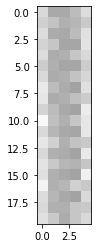

In [30]:
plt.imshow(x_images[0],vmin=0,vmax=1,cmap='gray')

## Modelo


In [75]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(64, 3, activation='relu', input_shape=(20, 5)))
model.add(tf.keras.layers.Conv1D(64, 3, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(3))
model.add(tf.keras.layers.Conv1D(128, 3, activation='relu'))
model.add(tf.keras.layers.Conv1D(128, 3, activation='relu'))
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(15, activation='softmax'))
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_32 (Conv1D)           (None, 18, 64)            1024      
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 16, 64)            12352     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 3, 128)            24704     
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 1, 128)            49280     
_________________________________________________________________
global_average_pooling1d_8 ( (None, 128)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)              

In [0]:
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=["sparse_categorical_accuracy"])


In [77]:
history = model.fit(x_train, y_train, validation_split=0.25 ,batch_size=16, epochs=500 , verbose = 1)

Train on 228 samples, validate on 76 samples
Epoch 1/500
228/228 [==============================] - 0s 2ms/sample - loss: 2.7061 - sparse_categorical_accuracy: 0.0746 - val_loss: 2.6908 - val_sparse_categorical_accuracy: 0.0921
Epoch 2/500
228/228 [==============================] - 0s 560us/sample - loss: 2.6322 - sparse_categorical_accuracy: 0.1447 - val_loss: 2.6402 - val_sparse_categorical_accuracy: 0.0789
Epoch 3/500
228/228 [==============================] - 0s 659us/sample - loss: 2.4414 - sparse_categorical_accuracy: 0.2193 - val_loss: 2.4550 - val_sparse_categorical_accuracy: 0.1184
Epoch 4/500
228/228 [==============================] - 0s 547us/sample - loss: 2.1292 - sparse_categorical_accuracy: 0.2632 - val_loss: 2.1416 - val_sparse_categorical_accuracy: 0.1184
Epoch 5/500
228/228 [==============================] - 0s 617us/sample - loss: 1.9406 - sparse_categorical_accuracy: 0.2895 - val_loss: 1.9505 - val_sparse_categorical_accuracy: 0.2237
Epoch 6/500
228/228 [===========

### Plot training & validation accuracy values
### Plot training & validation loss val

In [0]:
def visualzation_accuracy_loss_values_epochs(history):
  fig, axs = plt.subplots(1, 2,figsize=(15, 5))
  axs[0].plot(history.history['sparse_categorical_accuracy'])
  axs[0].plot(history.history['val_sparse_categorical_accuracy'])
  axs[0].set_title('Model accuracy')
  axs[0].set_ylabel('Accuracy')
  axs[0].set_xlabel('Epoch')
  axs[0].legend(['Train', 'Test'], loc='upper left')
  axs[1].plot(history.history['loss'])
  axs[1].plot(history.history['val_loss'])
  axs[1].set_title('Model loss')
  axs[1].set_ylabel('Loss')
  axs[1].set_xlabel('Epoch')
  axs[1].legend(['Train', 'Test'], loc='upper left')

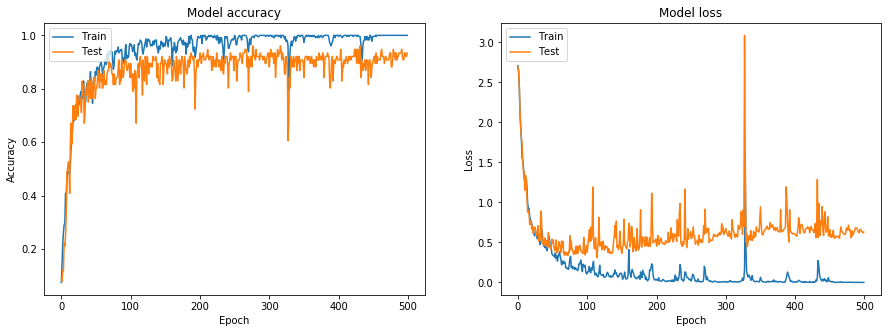

In [78]:
visualzation_accuracy_loss_values_epochs(history)

In [79]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test accuracy: {}".format(test_accuracy))

34/34 [==============================] - 0s 555us/sample - loss: 1.2955 - sparse_categorical_accuracy: 0.8824
Test accuracy: 0.8823529481887817


#### Early Stopping

In [92]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(64, 3, activation='relu', input_shape=(20, 5)))
model.add(tf.keras.layers.Conv1D(64, 3, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(3))
model.add(tf.keras.layers.Conv1D(128, 3, activation='relu'))
model.add(tf.keras.layers.Conv1D(128, 3, activation='relu'))
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dense(15, activation='softmax'))
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_44 (Conv1D)           (None, 18, 64)            1024      
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 16, 64)            12352     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 5, 64)             0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 3, 128)            24704     
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 1, 128)            49280     
_________________________________________________________________
global_average_pooling1d_11  (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 15)              

In [0]:
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=["sparse_categorical_accuracy"])


In [0]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto',restore_best_weights=True)

In [95]:
history = model.fit(x_train, y_train, validation_split=0.25,callbacks=[monitor] ,batch_size=16, epochs=500 , verbose = 1)

Train on 228 samples, validate on 76 samples
Epoch 1/500
228/228 [==============================] - 0s 2ms/sample - loss: 2.7019 - sparse_categorical_accuracy: 0.0965 - val_loss: 2.7213 - val_sparse_categorical_accuracy: 0.0526
Epoch 2/500
228/228 [==============================] - 0s 517us/sample - loss: 2.6338 - sparse_categorical_accuracy: 0.1623 - val_loss: 2.6587 - val_sparse_categorical_accuracy: 0.0921
Epoch 3/500
228/228 [==============================] - 0s 523us/sample - loss: 2.4669 - sparse_categorical_accuracy: 0.2368 - val_loss: 2.4661 - val_sparse_categorical_accuracy: 0.1053
Epoch 4/500
228/228 [==============================] - 0s 550us/sample - loss: 2.1303 - sparse_categorical_accuracy: 0.2763 - val_loss: 2.1152 - val_sparse_categorical_accuracy: 0.2500
Epoch 5/500
228/228 [==============================] - 0s 547us/sample - loss: 1.7665 - sparse_categorical_accuracy: 0.3684 - val_loss: 1.7357 - val_sparse_categorical_accuracy: 0.3289
Epoch 6/500
228/228 [===========

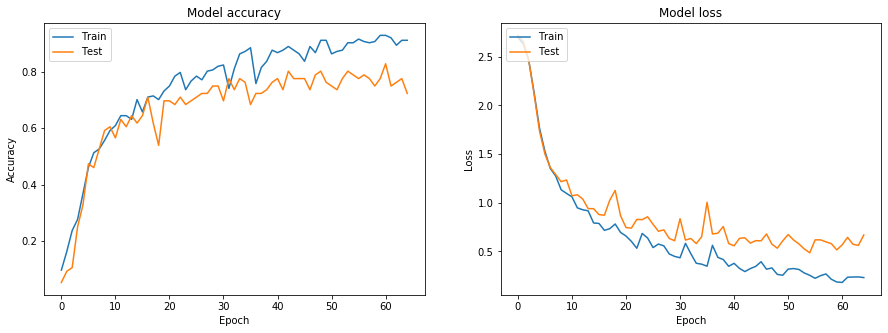

In [96]:
visualzation_accuracy_loss_values_epochs(history)

In [97]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test accuracy: {}".format(test_accuracy))

34/34 [==============================] - 0s 463us/sample - loss: 0.4776 - sparse_categorical_accuracy: 0.8529
Test accuracy: 0.8529411554336548


####Dropout 


In [98]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(64, 3, activation='relu', input_shape=(20, 5)))
model.add(tf.keras.layers.Conv1D(64, 3, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(3))
model.add(tf.keras.layers.Conv1D(128, 3, activation='relu'))
model.add(tf.keras.layers.Conv1D(128, 3, activation='relu'))
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(15, activation='softmax'))
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_48 (Conv1D)           (None, 18, 64)            1024      
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 16, 64)            12352     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 5, 64)             0         
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 3, 128)            24704     
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 1, 128)            49280     
_________________________________________________________________
global_average_pooling1d_12  (None, 128)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)             

In [0]:
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=["sparse_categorical_accuracy"])

In [100]:
history = model.fit(x_train, y_train, validation_split=0.25,callbacks=[monitor] ,batch_size=16, epochs=500 , verbose = 1)

Train on 228 samples, validate on 76 samples
Epoch 1/500
228/228 [==============================] - 1s 2ms/sample - loss: 2.7040 - sparse_categorical_accuracy: 0.0746 - val_loss: 2.7104 - val_sparse_categorical_accuracy: 0.0526
Epoch 2/500
228/228 [==============================] - 0s 649us/sample - loss: 2.6622 - sparse_categorical_accuracy: 0.1096 - val_loss: 2.7177 - val_sparse_categorical_accuracy: 0.0526
Epoch 3/500
228/228 [==============================] - 0s 666us/sample - loss: 2.6032 - sparse_categorical_accuracy: 0.1404 - val_loss: 2.6345 - val_sparse_categorical_accuracy: 0.1053
Epoch 4/500
228/228 [==============================] - 0s 632us/sample - loss: 2.4258 - sparse_categorical_accuracy: 0.1886 - val_loss: 2.4344 - val_sparse_categorical_accuracy: 0.1447
Epoch 5/500
228/228 [==============================] - 0s 613us/sample - loss: 2.2054 - sparse_categorical_accuracy: 0.2325 - val_loss: 2.3011 - val_sparse_categorical_accuracy: 0.1184
Epoch 6/500
228/228 [===========

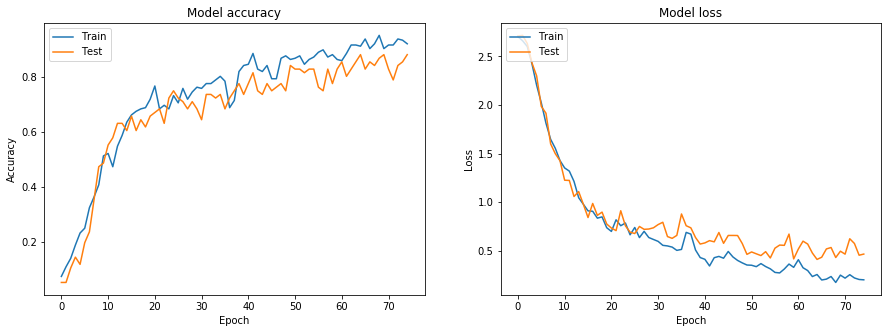

In [101]:
visualzation_accuracy_loss_values_epochs(history)

In [102]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test accuracy: {}".format(test_accuracy))

34/34 [==============================] - 0s 277us/sample - loss: 0.4416 - sparse_categorical_accuracy: 0.8824
Test accuracy: 0.8823529481887817


####Dropout +  Early Stopping

In [103]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(64, 3, activation='relu', input_shape=(20, 5)))
model.add(tf.keras.layers.Conv1D(64, 3, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(3))
model.add(tf.keras.layers.Conv1D(128, 3, activation='relu'))
model.add(tf.keras.layers.Conv1D(128, 3, activation='relu'))
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(15, activation='softmax'))
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_52 (Conv1D)           (None, 18, 64)            1024      
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 16, 64)            12352     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 5, 64)             0         
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 3, 128)            24704     
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 1, 128)            49280     
_________________________________________________________________
global_average_pooling1d_13  (None, 128)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)             

In [0]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto',restore_best_weights=True)

In [0]:
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=["sparse_categorical_accuracy"])

In [106]:
history = model.fit(x_train, y_train, validation_split=0.25,callbacks=[monitor] ,batch_size=16, epochs=500 , verbose = 1)

Train on 228 samples, validate on 76 samples
Epoch 1/500
228/228 [==============================] - 1s 2ms/sample - loss: 2.6996 - sparse_categorical_accuracy: 0.1096 - val_loss: 2.7118 - val_sparse_categorical_accuracy: 0.0658
Epoch 2/500
228/228 [==============================] - 0s 572us/sample - loss: 2.6385 - sparse_categorical_accuracy: 0.1491 - val_loss: 2.6686 - val_sparse_categorical_accuracy: 0.0658
Epoch 3/500
228/228 [==============================] - 0s 552us/sample - loss: 2.5184 - sparse_categorical_accuracy: 0.2281 - val_loss: 2.5853 - val_sparse_categorical_accuracy: 0.1053
Epoch 4/500
228/228 [==============================] - 0s 630us/sample - loss: 2.3139 - sparse_categorical_accuracy: 0.2325 - val_loss: 2.3753 - val_sparse_categorical_accuracy: 0.1447
Epoch 5/500
228/228 [==============================] - 0s 547us/sample - loss: 2.1634 - sparse_categorical_accuracy: 0.2368 - val_loss: 2.2523 - val_sparse_categorical_accuracy: 0.0789
Epoch 6/500
228/228 [===========

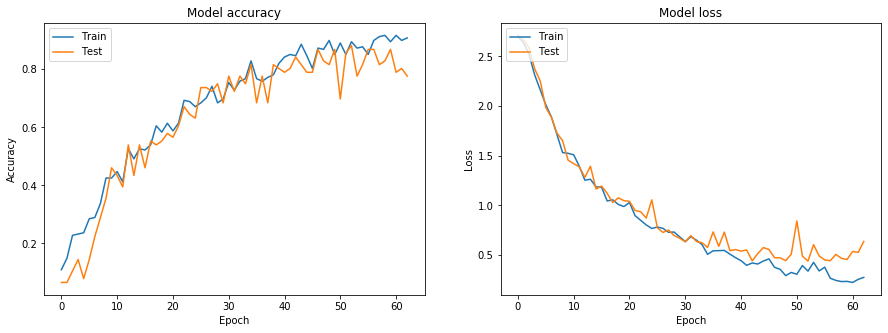

In [107]:
visualzation_accuracy_loss_values_epochs(history)

In [108]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test accuracy: {}".format(test_accuracy))

34/34 [==============================] - 0s 476us/sample - loss: 0.4961 - sparse_categorical_accuracy: 0.8824
Test accuracy: 0.8823529481887817
